# Predicting COVID-19 Infections with LSTM in Romania

> *by Daniel Traian Pele*

Acknowlegments: this notebook is based on the work of Yohan Chung: https://www.kaggle.com/yohancheong/predicting-covid-19-infections-with-lstm.
            
The datatsets are provided by Johns Hopkins University and include the COVID-19 confirmed cases & fatalities for Romania.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import os
import random as rn

os.environ['PYTHONHASHSEED'] = '0'

# Setting the seed for numpy-generated random numbers
    np.random.seed(1234)

# Setting the seed for python random numbers
rn.seed(1234)

# Setting the graph-level random seed.
tf.random.set_seed(1234)



# pd.set_option('display.float_format', lambda x: '%.20f' % x)

train_df = pd.read_csv('D:/Python/Covid-19 Forecasting/Romania/JH/train.csv') # historical data
test_df = pd.read_csv('D:/Python/Covid-19 Forecasting/Romania/JH/test.csv') # predictions to be filled

IndentationError: unexpected indent (<ipython-input-15-6ccf616dd109>, line 12)

*Cleansing & Transforming Data*


* Filling blank cells with default value
* Removing special char which can malfunction computation
* Converting datetime to day count from the starting date of data
* Scaling data to lower values

In [ ]:
train_df = train_df.fillna({'Province_State': 'Unknown'})
test_df = test_df.fillna({'Province_State': 'Unknown'})
train_df['Country_Region']= train_df['Country_Region'].str.replace("'", "")
train_df['Province_State']= train_df['Province_State'].str.replace("'", "")
test_df['Country_Region']= test_df['Country_Region'].str.replace("'", "")
test_df['Province_State']= test_df['Province_State'].str.replace("'", "")
train_df.isna().sum()

In [ ]:
def to_datetime(dt):
    return datetime.datetime.strptime(dt, '%Y-%m-%d')

def count_days(dt):
    return (dt - datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")).days

train_df['Date_dt'] = train_df['Date'].map(to_datetime)
train_df['Day'] = train_df['Date_dt'].map(count_days)
test_df['Date_dt'] = test_df['Date'].map(to_datetime)
test_df['Day'] = test_df['Date_dt'].map(count_days)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Min-Max Scaler
scaler_c = MinMaxScaler(feature_range=(0, 100))
train_df['ConfirmedCases_scaled'] = None
train_df[['ConfirmedCases_scaled']] = scaler_c.fit_transform(train_df[['ConfirmedCases']])

scaler_f = MinMaxScaler(feature_range=(0, 100))
train_df['Fatalities_scaled'] = None
train_df[['Fatalities_scaled']] = scaler_f.fit_transform(train_df[['Fatalities']])

# Get dummy columns for geo location
geo_columns = []
for i in range(294):
    geo_columns.append('Geo_{}'.format(i))
train_df.drop(columns=geo_columns, inplace=True, errors='ignore')

lbl_encoder = LabelEncoder()
scaler_g = MinMaxScaler(feature_range=(0, 1))
hot_encoder = OneHotEncoder(sparse=False)
train_df['Geo'] = train_df['Country_Region'].astype(str) + '_' + train_df['Province_State'].astype(str)
train_df[['Geo']] = lbl_encoder.fit_transform(train_df[['Geo']])
train_df = pd.get_dummies(train_df, prefix_sep="_", columns=['Geo'])

train_df[['ConfirmedCases', 'ConfirmedCases_scaled', 'Fatalities', 'Fatalities_scaled',  'Geo_0']].head()    

*Preparing Model Input & Target*
The sequential input data with the historical steps of 7, which will be time series to predict the confirmed cases on the next day.

In [16]:
historical_steps = 7
n_output_node = 1

def make_sequential_input(df):
    
    inputs_c, inputs_f, inputs_geo, targets_c, targets_f = [], [], [], [], []
    
    for i in range(len(df) - historical_steps - 1):
        
        if df.iloc[i]['Country_Region'] == df.iloc[i + historical_steps]['Country_Region'] and \
            df.iloc[i]['Province_State'] == df.iloc[i + historical_steps]['Province_State']:
            
            # iloc[a:b] startnig from index 'a' and ending before b
            inputs_c.append(np.array(df.iloc[i : i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # time seires until t-1
            inputs_f.append(np.array(df.iloc[i : i + historical_steps][['Fatalities_scaled']]).tolist()) # time seires until t-1
            inputs_geo.append(np.array(df.iloc[i + historical_steps][geo_columns]).tolist())
            targets_c.append(np.array(df.iloc[i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # result data at time t
            targets_f.append(np.array(df.iloc[i + historical_steps][['Fatalities_scaled']]).tolist()) # result data at time t
              
    return inputs_c, inputs_f, inputs_geo, targets_c, targets_f

# Make sequential input for training and validation
train_inputs, train_inputs_f, train_inputs_geo, train_targets_c, train_targets_f = make_sequential_input(train_df)

print('Train input shape: {}'.format(np.shape(train_inputs)))
print('Train input geo shape: {}'.format(np.shape(train_inputs_geo)))

Train input shape: (21419, 7, 1)
Train input geo shape: (21419, 294)


The validation dataset out of the prepared for modelling.

In [17]:
import random

max_index = np.array(train_inputs).shape[0] - 1
indices = []

for i in range(int(max_index*0.20)):
    indices.append(random.randint(0, max_index))

val_inputs = [ train_inputs[i] for i in indices ]
val_inputs_f = [ train_inputs_f[i] for i in indices ]
val_inputs_geo = [ train_inputs_geo[i] for i in indices  ] 
val_targets_c = [ train_targets_c[i] for i in indices ]
val_targets_f = [ train_targets_f[i] for i in indices ]

train_inputs = [ elem for i, elem in enumerate(train_inputs) if i not in indices ] 
train_inputs_f = [ elem for i, elem in enumerate(train_inputs_f) if i not in indices ] 
train_inputs_geo = [ elem for i, elem in enumerate(train_inputs_geo) if i not in indices ] 
train_targets_c = [ elem for i, elem in enumerate(train_targets_c) if i not in indices ] 
train_targets_f = [ elem for i, elem in enumerate(train_targets_f) if i not in indices ] 

pd.set_option('display.max_colwidth', -1)
print('No. train data: {}'.format(len(train_inputs)))
print('No. validation data: {}'.format(len(val_inputs)))


No. train data: 17527
No. validation data: 4283


C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# LSTM with Initial State
MSLE - Mean squared log error which give more penalty on underestimation over overestimation, since the trend is likely to grow up.

The following codes were used when creating LSTM model with time series data for confirmed cases,
as well as geo location.

Epoch 1/200
274/274 [==============================] - 2s 7ms/step - loss: 0.0421 - mean_absolute_error: 0.4080 - mean_squared_error: 15.9820 - val_loss: 0.0165 - val_mean_absolute_error: 0.3259 - val_mean_squared_error: 13.2837
Epoch 2/200
274/274 [==============================] - 1s 5ms/step - loss: 0.0141 - mean_absolute_error: 0.3138 - mean_squared_error: 12.6133 - val_loss: 0.0115 - val_mean_absolute_error: 0.2836 - val_mean_squared_error: 11.7298
Epoch 3/200
274/274 [==============================] - 1s 5ms/step - loss: 0.0105 - mean_absolute_error: 0.2840 - mean_squared_error: 11.2729 - val_loss: 0.0089 - val_mean_absolute_error: 0.2613 - val_mean_squared_error: 10.5391
Epoch 4/200
274/274 [==============================] - 2s 5ms/step - loss: 0.0082 - mean_absolute_error: 0.2619 - mean_squared_error: 10.1510 - val_loss: 0.0073 - val_mean_absolute_error: 0.2513 - val_mean_squared_error: 9.5583
Epoch 5/200
274/274 [==============================] - 2s 6ms/step - loss: 0.0067 - m

274/274 [==============================] - 2s 5ms/step - loss: 4.8077e-04 - mean_absolute_error: 0.0646 - mean_squared_error: 0.9265 - val_loss: 4.0387e-04 - val_mean_absolute_error: 0.0516 - val_mean_squared_error: 0.7225
Epoch 37/200
274/274 [==============================] - 2s 6ms/step - loss: 4.4801e-04 - mean_absolute_error: 0.0597 - mean_squared_error: 0.7777 - val_loss: 3.5731e-04 - val_mean_absolute_error: 0.0508 - val_mean_squared_error: 0.6680
Epoch 38/200
274/274 [==============================] - 1s 5ms/step - loss: 4.1736e-04 - mean_absolute_error: 0.0580 - mean_squared_error: 0.8035 - val_loss: 3.2511e-04 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.6032
Epoch 39/200
274/274 [==============================] - 1s 5ms/step - loss: 4.2784e-04 - mean_absolute_error: 0.0595 - mean_squared_error: 0.7708 - val_loss: 3.2026e-04 - val_mean_absolute_error: 0.0447 - val_mean_squared_error: 0.5493
Epoch 40/200
274/274 [==============================] - 1s 5ms/step -

Epoch 71/200
274/274 [==============================] - 1s 5ms/step - loss: 2.9720e-04 - mean_absolute_error: 0.0392 - mean_squared_error: 0.2179 - val_loss: 2.6094e-04 - val_mean_absolute_error: 0.0259 - val_mean_squared_error: 0.0661
Epoch 72/200
274/274 [==============================] - 2s 6ms/step - loss: 2.9040e-04 - mean_absolute_error: 0.0399 - mean_squared_error: 0.1765 - val_loss: 2.0962e-04 - val_mean_absolute_error: 0.0285 - val_mean_squared_error: 0.0735
Epoch 73/200
274/274 [==============================] - 1s 5ms/step - loss: 2.8238e-04 - mean_absolute_error: 0.0379 - mean_squared_error: 0.1744 - val_loss: 1.9492e-04 - val_mean_absolute_error: 0.0229 - val_mean_squared_error: 0.0589
Epoch 74/200
274/274 [==============================] - 2s 6ms/step - loss: 3.2833e-04 - mean_absolute_error: 0.0418 - mean_squared_error: 0.2083 - val_loss: 2.1175e-04 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0782
Epoch 75/200
274/274 [==============================] - 

Epoch 106/200
274/274 [==============================] - 2s 6ms/step - loss: 2.7277e-04 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0972 - val_loss: 2.4754e-04 - val_mean_absolute_error: 0.0259 - val_mean_squared_error: 0.0308
Epoch 107/200
274/274 [==============================] - 1s 5ms/step - loss: 2.6037e-04 - mean_absolute_error: 0.0347 - mean_squared_error: 0.1012 - val_loss: 2.0405e-04 - val_mean_absolute_error: 0.0214 - val_mean_squared_error: 0.0292
Epoch 108/200
274/274 [==============================] - 1s 5ms/step - loss: 2.7048e-04 - mean_absolute_error: 0.0358 - mean_squared_error: 0.1001 - val_loss: 2.3925e-04 - val_mean_absolute_error: 0.0272 - val_mean_squared_error: 0.0440
Epoch 109/200
274/274 [==============================] - 1s 5ms/step - loss: 2.6123e-04 - mean_absolute_error: 0.0342 - mean_squared_error: 0.1096 - val_loss: 1.8063e-04 - val_mean_absolute_error: 0.0196 - val_mean_squared_error: 0.0259
Epoch 110/200
274/274 [=============================

274/274 [==============================] - 2s 6ms/step - loss: 2.6336e-04 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0921 - val_loss: 1.8161e-04 - val_mean_absolute_error: 0.0215 - val_mean_squared_error: 0.0332
Epoch 141/200
274/274 [==============================] - 1s 5ms/step - loss: 2.4235e-04 - mean_absolute_error: 0.0332 - mean_squared_error: 0.0882 - val_loss: 2.7234e-04 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0207
Epoch 142/200
274/274 [==============================] - 1s 5ms/step - loss: 2.5177e-04 - mean_absolute_error: 0.0340 - mean_squared_error: 0.0878 - val_loss: 1.9587e-04 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 0.0187
Epoch 143/200
274/274 [==============================] - 2s 6ms/step - loss: 2.3587e-04 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0797 - val_loss: 2.3494e-04 - val_mean_absolute_error: 0.0267 - val_mean_squared_error: 0.0426
Epoch 144/200
274/274 [==============================] - 1s 5ms/st

Epoch 175/200
274/274 [==============================] - 1s 5ms/step - loss: 2.3950e-04 - mean_absolute_error: 0.0307 - mean_squared_error: 0.0708 - val_loss: 1.7356e-04 - val_mean_absolute_error: 0.0195 - val_mean_squared_error: 0.0202
Epoch 176/200
274/274 [==============================] - 1s 5ms/step - loss: 2.2309e-04 - mean_absolute_error: 0.0304 - mean_squared_error: 0.0675 - val_loss: 1.6315e-04 - val_mean_absolute_error: 0.0160 - val_mean_squared_error: 0.0130
Epoch 177/200
274/274 [==============================] - 2s 6ms/step - loss: 2.3915e-04 - mean_absolute_error: 0.0339 - mean_squared_error: 0.0996 - val_loss: 2.4179e-04 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 0.0152
Epoch 178/200
274/274 [==============================] - 1s 5ms/step - loss: 2.3985e-04 - mean_absolute_error: 0.0326 - mean_squared_error: 0.0786 - val_loss: 1.9262e-04 - val_mean_absolute_error: 0.0190 - val_mean_squared_error: 0.0180
Epoch 179/200
274/274 [=============================

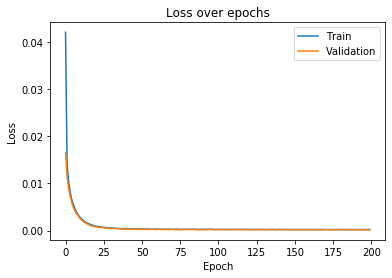

Epoch 1/200
274/274 [==============================] - 2s 8ms/step - loss: 0.0167 - mean_absolute_error: 0.1602 - mean_squared_error: 5.8478 - val_loss: 0.0073 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 5.5210
Epoch 2/200
274/274 [==============================] - 1s 5ms/step - loss: 0.0060 - mean_absolute_error: 0.1250 - mean_squared_error: 4.7443 - val_loss: 0.0053 - val_mean_absolute_error: 0.1181 - val_mean_squared_error: 4.9841
Epoch 3/200
274/274 [==============================] - 1s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.1100 - mean_squared_error: 4.3282 - val_loss: 0.0041 - val_mean_absolute_error: 0.1062 - val_mean_squared_error: 4.6082
Epoch 4/200
274/274 [==============================] - 2s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0994 - mean_squared_error: 4.0199 - val_loss: 0.0037 - val_mean_absolute_error: 0.1048 - val_mean_squared_error: 4.3203
Epoch 5/200
274/274 [==============================] - 2s 6ms/step - loss: 0.0029 - mean_abs

274/274 [==============================] - 2s 5ms/step - loss: 3.1210e-04 - mean_absolute_error: 0.0344 - mean_squared_error: 0.7010 - val_loss: 2.7532e-04 - val_mean_absolute_error: 0.0341 - val_mean_squared_error: 0.6671
Epoch 37/200
274/274 [==============================] - 1s 5ms/step - loss: 2.7255e-04 - mean_absolute_error: 0.0319 - mean_squared_error: 0.6354 - val_loss: 2.4202e-04 - val_mean_absolute_error: 0.0327 - val_mean_squared_error: 0.6217
Epoch 38/200
274/274 [==============================] - 1s 5ms/step - loss: 2.8557e-04 - mean_absolute_error: 0.0330 - mean_squared_error: 0.6449 - val_loss: 2.2342e-04 - val_mean_absolute_error: 0.0301 - val_mean_squared_error: 0.5714
Epoch 39/200
274/274 [==============================] - 2s 6ms/step - loss: 2.8577e-04 - mean_absolute_error: 0.0323 - mean_squared_error: 0.6197 - val_loss: 2.2420e-04 - val_mean_absolute_error: 0.0324 - val_mean_squared_error: 0.5517
Epoch 40/200
274/274 [==============================] - 2s 6ms/step -

Epoch 71/200
274/274 [==============================] - 2s 6ms/step - loss: 1.5871e-04 - mean_absolute_error: 0.0195 - mean_squared_error: 0.1592 - val_loss: 1.6934e-04 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 0.1406
Epoch 72/200
274/274 [==============================] - 2s 6ms/step - loss: 1.5134e-04 - mean_absolute_error: 0.0197 - mean_squared_error: 0.1353 - val_loss: 1.0331e-04 - val_mean_absolute_error: 0.0153 - val_mean_squared_error: 0.0780
Epoch 73/200
274/274 [==============================] - 1s 5ms/step - loss: 1.7005e-04 - mean_absolute_error: 0.0205 - mean_squared_error: 0.1346 - val_loss: 1.0038e-04 - val_mean_absolute_error: 0.0128 - val_mean_squared_error: 0.0602
Epoch 74/200
274/274 [==============================] - 1s 5ms/step - loss: 1.6930e-04 - mean_absolute_error: 0.0195 - mean_squared_error: 0.0992 - val_loss: 1.0131e-04 - val_mean_absolute_error: 0.0140 - val_mean_squared_error: 0.0676
Epoch 75/200
274/274 [==============================] - 

Epoch 106/200
274/274 [==============================] - 2s 6ms/step - loss: 1.3022e-04 - mean_absolute_error: 0.0166 - mean_squared_error: 0.0631 - val_loss: 8.1182e-05 - val_mean_absolute_error: 0.0107 - val_mean_squared_error: 0.0243
Epoch 107/200
274/274 [==============================] - 2s 6ms/step - loss: 1.2977e-04 - mean_absolute_error: 0.0166 - mean_squared_error: 0.0545 - val_loss: 9.8678e-05 - val_mean_absolute_error: 0.0114 - val_mean_squared_error: 0.0208
Epoch 108/200
274/274 [==============================] - 2s 6ms/step - loss: 1.3682e-04 - mean_absolute_error: 0.0162 - mean_squared_error: 0.0558 - val_loss: 1.3094e-04 - val_mean_absolute_error: 0.0186 - val_mean_squared_error: 0.0470
Epoch 109/200
274/274 [==============================] - 2s 6ms/step - loss: 1.4109e-04 - mean_absolute_error: 0.0174 - mean_squared_error: 0.0627 - val_loss: 8.0424e-05 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 0.0194
Epoch 110/200
274/274 [=============================

274/274 [==============================] - 2s 6ms/step - loss: 1.1983e-04 - mean_absolute_error: 0.0152 - mean_squared_error: 0.0537 - val_loss: 1.0203e-04 - val_mean_absolute_error: 0.0146 - val_mean_squared_error: 0.0282
Epoch 141/200
274/274 [==============================] - 2s 6ms/step - loss: 1.2332e-04 - mean_absolute_error: 0.0152 - mean_squared_error: 0.0517 - val_loss: 9.0353e-05 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 0.0208
Epoch 142/200
274/274 [==============================] - 2s 6ms/step - loss: 1.1580e-04 - mean_absolute_error: 0.0151 - mean_squared_error: 0.0457 - val_loss: 1.0235e-04 - val_mean_absolute_error: 0.0138 - val_mean_squared_error: 0.0286
Epoch 143/200
274/274 [==============================] - 2s 6ms/step - loss: 1.1949e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 0.0447 - val_loss: 8.3397e-05 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 0.0174
Epoch 144/200
274/274 [==============================] - 2s 6ms/st

Epoch 175/200
274/274 [==============================] - 1s 5ms/step - loss: 1.1543e-04 - mean_absolute_error: 0.0137 - mean_squared_error: 0.0268 - val_loss: 7.6569e-05 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 0.0092
Epoch 176/200
274/274 [==============================] - 1s 5ms/step - loss: 1.0980e-04 - mean_absolute_error: 0.0140 - mean_squared_error: 0.0327 - val_loss: 8.1386e-05 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 0.0075
Epoch 177/200
274/274 [==============================] - 1s 5ms/step - loss: 1.2114e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0309 - val_loss: 8.9741e-05 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 0.0097
Epoch 178/200
274/274 [==============================] - 1s 5ms/step - loss: 1.2473e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0351 - val_loss: 1.2324e-04 - val_mean_absolute_error: 0.0131 - val_mean_squared_error: 0.0152
Epoch 179/200
274/274 [=============================

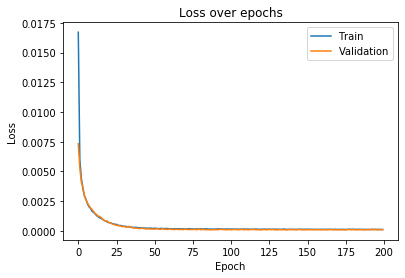

INFO:tensorflow:Assets written to: model_c_with_state\assets
INFO:tensorflow:Assets written to: model_f_with_state\assets


In [18]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

n_output_node = 1
input_shape=np.array(train_inputs).shape[-2:]
input_shape_geo=np.array(train_inputs_geo).shape

batch_size = 64
epochs = 200
lr = 0.001


def create_model(inputs, inputs_geo, targets, v_inputs, v_inputs_geo, v_targets):
    
    geo_input = Input(shape=(294,), name='input_geo')
    h_state = Dense(64, activation='relu')(geo_input)
    h_state = Dense(64, activation='relu')(h_state)
    c_state = Dense(64, activation='relu')(geo_input)
    c_state = Dense(64, activation='relu')(c_state)

    ts_input = Input(shape=input_shape, name='input_ts')
    lstm = LSTM(64, return_sequences=True)(ts_input, initial_state=[ h_state, c_state ])
    lstm = Dropout(0.05)(lstm)
    lstm = LSTM(32)(lstm)
    lstm = Dropout(0.05)(lstm)
    main_output = Dense(n_output_node, activation='relu', name='output_main')(lstm)
    
    model = Model(inputs=[ geo_input, ts_input ], outputs=main_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), \
                  loss=tf.keras.losses.MSLE, metrics=[ tf.keras.metrics.MeanAbsoluteError(),
                                                      tf.keras.metrics.MeanSquaredError() ])
    
    history = model.fit([ inputs_geo, inputs ],  targets, \
              epochs=epochs, \
              batch_size=batch_size, \
              validation_data=({ 'input_geo': v_inputs_geo, 'input_ts': v_inputs },{ 'output_main': v_targets}))

    scores = model.evaluate({ 'input_geo': inputs_geo, 'input_ts': inputs }, targets)
    print("Model Accuracy: {}".format(scores))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return model
                        
    

model_cases = create_model(np.array(train_inputs), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
model_fatality = create_model(np.array(train_inputs_f), np.array(train_inputs_geo), np.array(train_targets_f), np.array(val_inputs_f), np.array(val_inputs_geo), np.array(val_targets_f))

model_cases.save('model_c_with_state')
model_fatality.save('model_f_with_state')

# Interpreting Data

In [19]:
model_cases = tf.keras.models.load_model('model_c_with_state')
model_fatality = tf.keras.models.load_model('model_f_with_state')

In [20]:
def predict_cases(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['ConfirmedCases_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['ConfirmedCases']])
    
    predictions = model_cases.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['ConfirmedCases']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_c.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
    
def predict_fatality(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['Fatalities_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['Fatalities']])
    
    predictions = model_fatality.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['Fatalities']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_f.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
      

predict_cases('Romania', 'Unknown')


predict_fatality('Romania', 'Unknown')


Inputs: [2245.0, 2460.0, 2738.0, 3183.0, 3613.0, 3864.0, 4057.0], Pred: [[4541.23914303]], Expected: [4417.0]
Inputs: [82.0, 92.0, 115.0, 133.0, 146.0, 151.0, 176.0], Pred: [[192.69965698]], Expected: [197.0]


In [21]:
import time

test_df['ConfirmedCases'] = None
test_df['Fatalities'] = None
geo_df = None

tic = time.perf_counter()
temp_df = train_df

# For each test row
for i in range(len(test_df)):
    
    if i%1000 == 0:
        toc = time.perf_counter()
        print('Looping throught the index {} - {:.2f} sec(s) taken...'.format(i, (toc-tic)))
   
    current = test_df.iloc[i]         
    geo_df = temp_df[(temp_df.Country_Region == current.Country_Region) & (temp_df.Province_State == current.Province_State) & (temp_df.Day >= (current.Day - historical_steps)) & (temp_df.Day <= (current.Day))]
        
     # Find historical steps in train data
    if not geo_df.empty and geo_df.shape[0] >=historical_steps:                 
        
        
        if geo_df.shape[0] == 8:
            input_geo = np.array(geo_df.iloc[-historical_steps-1][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
        else:
            input_geo = np.array(geo_df.iloc[-historical_steps][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
              
        test_df.loc[i, 'ConfirmedCases_scaled'] = pred[0][0]
        test_df.loc[i, 'Fatalities_scaled'] = pred_f[0][0]
        
        # Save current data in train_df for next if empty
        if geo_df.iloc[-1:,].Day.values[0] != current.Day:  
            
            new_item = { 'ConfirmedCases_scaled': pred[0][0], 'Fatalities_scaled': pred_f[0][0], 'Day': current.Day, \
                         'Country_Region': current.Country_Region, 'Province_State': current.Province_State }
            
            for j in range(len(geo_columns)):
                new_item['Geo_' + str(j)] = 1 if geo_df.iloc[-1:,]['Geo_' + str(j)].values[0] == 1 else 0
            
            temp_df = temp_df.append(new_item, ignore_index=True)

test_df[['ConfirmedCases']] = scaler_c.inverse_transform(test_df[['ConfirmedCases_scaled']])
test_df[['Fatalities']] = scaler_f.inverse_transform(test_df[['Fatalities_scaled']]) 

Looping throught the index 0 - 0.01 sec(s) taken...
Looping throught the index 1000 - 203.29 sec(s) taken...
Looping throught the index 2000 - 413.80 sec(s) taken...
Looping throught the index 3000 - 620.78 sec(s) taken...
Looping throught the index 4000 - 829.64 sec(s) taken...
Looping throught the index 5000 - 1038.91 sec(s) taken...
Looping throught the index 6000 - 1253.16 sec(s) taken...
Looping throught the index 7000 - 1469.24 sec(s) taken...
Looping throught the index 8000 - 1688.03 sec(s) taken...
Looping throught the index 9000 - 1907.01 sec(s) taken...
Looping throught the index 10000 - 2131.67 sec(s) taken...
Looping throught the index 11000 - 2358.80 sec(s) taken...
Looping throught the index 12000 - 2588.21 sec(s) taken...
Looping throught the index 13000 - 2817.91 sec(s) taken...


In [22]:
test_df[(test_df.Country_Region=='Romania') & (test_df.Province_State=='Unknown')].iloc[-35:,:]


,ForecastId,Province_State,Country_Region,Date,Date_dt,Day,ConfirmedCases,Fatalities,ConfirmedCases_scaled,Fatalities_scaled
8608,8609,Unknown,Romania,2020-04-03,2020-04-03,72,3101.005538,133.058008,2.184699,0.776890
8609,8610,Unknown,Romania,2020-04-04,2020-04-04,73,3530.188219,151.358692,2.487064,0.883743
8610,8611,Unknown,Romania,2020-04-05,2020-04-05,74,3956.238183,165.463974,2.787222,0.966100
8611,8612,Unknown,Romania,2020-04-06,2020-04-06,75,4272.415607,168.998795,3.009973,0.986739
8612,8613,Unknown,Romania,2020-04-07,2020-04-07,76,4541.239143,192.699657,3.199363,1.125122
8613,8614,Unknown,Romania,2020-04-08,2020-04-08,77,4880.215998,214.350899,3.438176,1.251538
8614,8615,Unknown,Romania,2020-04-09,2020-04-09,78,5323.454116,231.901045,3.750443,1.354009
8615,8616,Unknown,Romania,2020-04-10,2020-04-10,79,5757.450766,248.289282,4.056200,1.449695
8616,8617,Unknown,Romania,2020-04-11,2020-04-11,80,6166.136938,264.439721,4.344124,1.543993
8617,8618,Unknown,Romania,2020-04-12,2020-04-12,81,6579.005257,281.668974,4.634995,1.644590


In [23]:
def plot_by_country(country, state):

  
    hist_df = train_df[(train_df.Country_Region == country) & (train_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()
    pred_df = test_df[(test_df.Country_Region == country) & (test_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()
    print(pred_df)
    pred_df['Date']=pd.to_datetime(pred_df['Date'])  
    hist_df['Date']=pd.to_datetime(hist_df['Date'])  
    pred_df.set_index('Date',inplace=True)
    hist_df.set_index('Date',inplace=True)
    plt.title('Romania Confirmed Cases')
    plt.plot(hist_df.ConfirmedCases, label='Historical',color='blue')
    plt.plot(pred_df.ConfirmedCases, label='Predictive',color='red',linestyle='--')
    #plt.axvline(x='2020-03-16', color='r', linestyle='--', linewidth=1, label='State of Emergency')
    plt.xlabel('Day',fontsize=10)
    plt.ylabel('Confirmed Cases',fontsize=10)
    plt.xticks(rotation=90,fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.show()
    
    hist_df = train_df[(train_df.Country_Region == country) & (train_df.Province_State \
         == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'Fatalities': 'sum'}).reset_index()
    pred_df = test_df[(test_df.Country_Region == country) & (test_df.Province_State \
        == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'Fatalities': 'sum'}).reset_index()
    print(pred_df)
    
    pred_df['Date']=pd.to_datetime(pred_df['Date'])  
    hist_df['Date']=pd.to_datetime(hist_df['Date'])  
    pred_df.to_csv('D:/Python/Covid-19 Forecasting/Romania/Forecasts/LSTM.csv')
    pred_df.set_index('Date',inplace=True)
    hist_df.set_index('Date',inplace=True)
    plt.title('Romania Fatalities')
    plt.plot(hist_df.Fatalities, label='Historical',color='blue')
    plt.plot(pred_df.Fatalities, label='Predictive',color='red',linestyle='--')
    #plt.axvline(x='2020-03-16', color='r', linestyle='--', linewidth=1, label='State of Emergency')
    plt.xlabel('Day',fontsize=10)
    plt.ylabel('Deaths',fontsize=10)
    plt.xticks(rotation=90,fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.show()
    

   Country_Region Province_State  Day        Date  ConfirmedCases
0   Romania        Unknown        64   2020-03-26  1103.594613   
1   Romania        Unknown        65   2020-03-27  1247.167982   
2   Romania        Unknown        66   2020-03-28  1511.724345   
3   Romania        Unknown        67   2020-03-29  1711.334343   
4   Romania        Unknown        68   2020-03-30  2071.945632   
5   Romania        Unknown        69   2020-03-31  2399.684534   
6   Romania        Unknown        70   2020-04-01  2611.882427   
7   Romania        Unknown        71   2020-04-02  2841.476600   
8   Romania        Unknown        72   2020-04-03  3101.005538   
9   Romania        Unknown        73   2020-04-04  3530.188219   
10  Romania        Unknown        74   2020-04-05  3956.238183   
11  Romania        Unknown        75   2020-04-06  4272.415607   
12  Romania        Unknown        76   2020-04-07  4541.239143   
13  Romania        Unknown        77   2020-04-08  4880.215998   
14  Romani

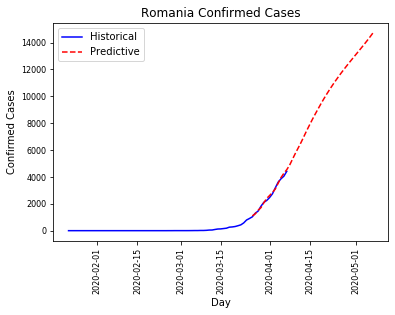

   Country_Region Province_State  Day        Date   Fatalities
0   Romania        Unknown        64   2020-03-26  22.846268  
1   Romania        Unknown        65   2020-03-27  31.013594  
2   Romania        Unknown        66   2020-03-28  35.557874  
3   Romania        Unknown        67   2020-03-29  47.425070  
4   Romania        Unknown        68   2020-03-30  55.019435  
5   Romania        Unknown        69   2020-03-31  78.943888  
6   Romania        Unknown        70   2020-04-01  98.645105  
7   Romania        Unknown        71   2020-04-02  110.430844 
8   Romania        Unknown        72   2020-04-03  133.058008 
9   Romania        Unknown        73   2020-04-04  151.358692 
10  Romania        Unknown        74   2020-04-05  165.463974 
11  Romania        Unknown        75   2020-04-06  168.998795 
12  Romania        Unknown        76   2020-04-07  192.699657 
13  Romania        Unknown        77   2020-04-08  214.350899 
14  Romania        Unknown        78   2020-04-09  231.

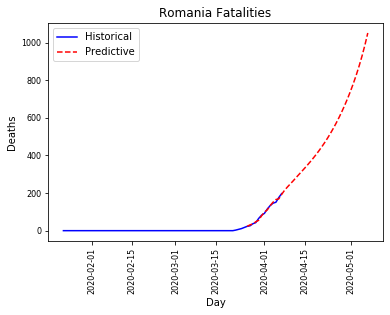

[None]

In [24]:
[ plot_by_country(country, state) for country, state in [ \
    ('Romania',  'Unknown')]]

In [25]:
test_df[['ForecastId', \
         'ConfirmedCases', 'Fatalities']].to_csv('D:/Python/Covid-19 Forecasting/Romania/JH/prediction.csv',\
                                                  index=False)